In [ ]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
%pwd

'/content'

In [ ]:
%cd drive/

/content/drive


In [ ]:
%cd /content/drive/MyDrive/dataset

/content/drive/MyDrive/dataset


In [ ]:
!ls

Brain  Knee  mask


**DLGAN Model Implementation**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import time
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms,utils,datasets
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
from IPython.display import clear_output

In [ ]:
assert torch.cuda.is_available()

In [ ]:
# use this for Sampling Ratio of 20%)
MASK = 'radial'
MASK_PERCENT = '20'

train_transforms = transforms.Compose([
		# transforms.ToPILImage(),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomRotation(90, fill=0),
		transforms.RandomCrop(244),
		transforms.Pad(6),
		transforms.ToTensor()
	])

In [ ]:
# use this for Sampling Ratio of 30%)
MASK = 'radial'
MASK_PERCENT = '30'

train_transforms = transforms.Compose([
		# transforms.ToPILImage(),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomRotation(90, fill=0),
		transforms.RandomCrop(244),
		transforms.Pad(6),
		transforms.ToTensor()
	])

In [ ]:
# use this for Sampling Ratio of 50%)
MASK = 'radial'
MASK_PERCENT = '50'

train_transforms = transforms.Compose([
		# transforms.ToPILImage(),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomRotation(90, fill=0),
		transforms.RandomCrop(244),
		transforms.Pad(6),
		transforms.ToTensor()
	])

In [ ]:
def RF(image, mask, batch = False):	#both image and mask arg are (2,256,256) tensors
  if not batch:
    image = image.permute(1,2,0)
    mask = mask.permute(1,2,0)
    frq = torch.fft(image, 2)
    res = torch.mul(frq, mask)
    res = res.permute(2,0,1)
    return res
  else:
    image = image.permute(0,2,3,1)
    mask = mask.permute(0,2,3,1)
    frq = torch.fft(image, 2)
    res = torch.mul(frq, mask)
    res = res.permute(0,3,1,2)
    return res

def FhRh(frq, batch = False):
  if not batch:
    frq = frq.permute(1,2,0)
    res = torch.ifft(frq, 2)
    res = torch.clamp(res, min=-1, max=1)
    res = res.permute(2,0,1)
    return res
  else:
    frq = frq.permute(0,2,3,1)
    res = torch.ifft(frq, 2)
    res = torch.clamp(res, min=-1, max=1)
    res = res.permute(0,3,1,2)
    return res

def displayTensor(tnsr, name="image"):	#input tensor is (2,256,256)
  real = tnsr[0]
  image = (real+1)*255/2
  image = np.array(image, dtype="uint8")
  plt.imshow(image, cmap='gray', vmin=0, vmax=255)

In [ ]:
DATASET = 'Knee'	#['brain', 'knees']
MASK = 'radial'		#['cartes', 'gauss', 'radial', 'spiral']
MASK_PRECENT = '20'	#[ '20', '30', '50']


datapath_train = './dataset/{}/db_train'.format(DATASET)
datapath_val = './dataset/{}/db_valid'.format(DATASET)
mask_path = './dataset/mask/{}/{}_{}.tif'.format(MASK, MASK, MASK_PRECENT)
PIK = './data.pkl'
MM = './minmax.pkl'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask/255
image_imag = np.zeros([256, 256])


us_train_data = np.zeros([100, 2, 256, 256])		#undersampled
us_val_data = np.zeros([100, 2, 256, 256])
train_data = np.zeros([100, 2, 256, 256])			#original image
val_data = np.zeros([100, 2, 256, 256])
RF_train_data = np.zeros([100, 2, 256, 256])		#in k-space
RF_val_data = np.zeros([100, 2, 256, 256])

i=0
for filename in os.listdir(datapath_train):
	image = cv2.imread('{}/{}'.format(datapath_train, filename))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	frq = RF(image, mask)
	RF_train_data[i,0] = np.real(frq)
	RF_train_data[i,1] = np.imag(frq)

	res = FhRh(frq)
	us_train_data[i,0] = np.real(res)
	us_train_data[i,1] = np.imag(res)

	train_data[i,0] = image
	train_data[i,1] = image_imag
	i = i+1

j=0
for filename in os.listdir(datapath_val):
	image = cv2.imread('{}/{}'.format(datapath_val, filename))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	frq = RF(image, mask)
	RF_val_data[j,0] = np.real(frq)
	RF_val_data[j,1] = np.imag(frq)

	res = FhRh(frq)
	us_val_data[j,0] = np.real(res)
	us_val_data[j,1] = np.imag(res)

	val_data[j,0] = image
	val_data[j,1] = image_imag
	j = j+1


min_us_data = np.min([us_train_data, us_val_data])
max_us_data = np.max([us_train_data, us_val_data])
us_train_data = 2*(us_train_data-min_us_data)/(max_us_data-min_us_data)-1
us_val_data = 2*(us_val_data-min_us_data)/(max_us_data-min_us_data)-1


min_data = np.min([train_data, val_data])
max_data = np.max([train_data, val_data])
train_data = 2*(train_data-min_data)/(max_data-min_data)-1
val_data = 2*(val_data-min_data)/(max_data-min_data)-1


min_RF_data = np.min([RF_train_data, RF_val_data])
max_RF_data = np.max([RF_train_data, RF_val_data])
RF_train_data = 2*(RF_train_data-min_RF_data)/(max_RF_data-min_RF_data)-1
RF_val_data = 2*(RF_val_data-min_RF_data)/(max_RF_data-min_RF_data)-1


DATA = [us_train_data, us_val_data, train_data, val_data, RF_train_data, RF_val_data]
MINMAX = [min_us_data, max_us_data, min_data, max_data, min_RF_data, max_RF_data]
def save_data():
	with open(PIK, "wb") as f:
		pkl.dump(DATA, f)

	with open(MM, "wb") as g:
		pkl.dump(MINMAX, g)



In [4]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [6]:
import os
folder_path = '/content/drive/MyDrive/dataset/Knee/db_train'
image_files = os.listdir(folder_path)
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
import os
folder_path = '/content/drive/MyDrive/dataset/Brain/db_train'
image_files = os.listdir(folder_path)

In [7]:
# Load and preprocess the images
images = []
for file in image_files:
    image_path = os.path.join(folder_path, file)
    image = Image.open(image_path)
    image = image.resize((28, 28))  # Resize the image to match GAN input size
    image = np.array(image) / 255.0  # Normalize the image to [0, 1] range
    images.append(image)

In [11]:
# DLGAN architecture
generator = Sequential([
    Dense(7 * 7 * 256, input_shape=(100,), activation='relu'),
    Reshape((7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
])

discriminator = Sequential([
    tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

# Loss function and optimizers
loss_fn = BinaryCrossentropy(from_logits=True)
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# GAN training loop
@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, 10])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        disc_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [12]:
# Training parameters
EPOCHS = 10
BATCH_SIZE = 256
NUM_EXAMPLES_TO_GENERATE = 5

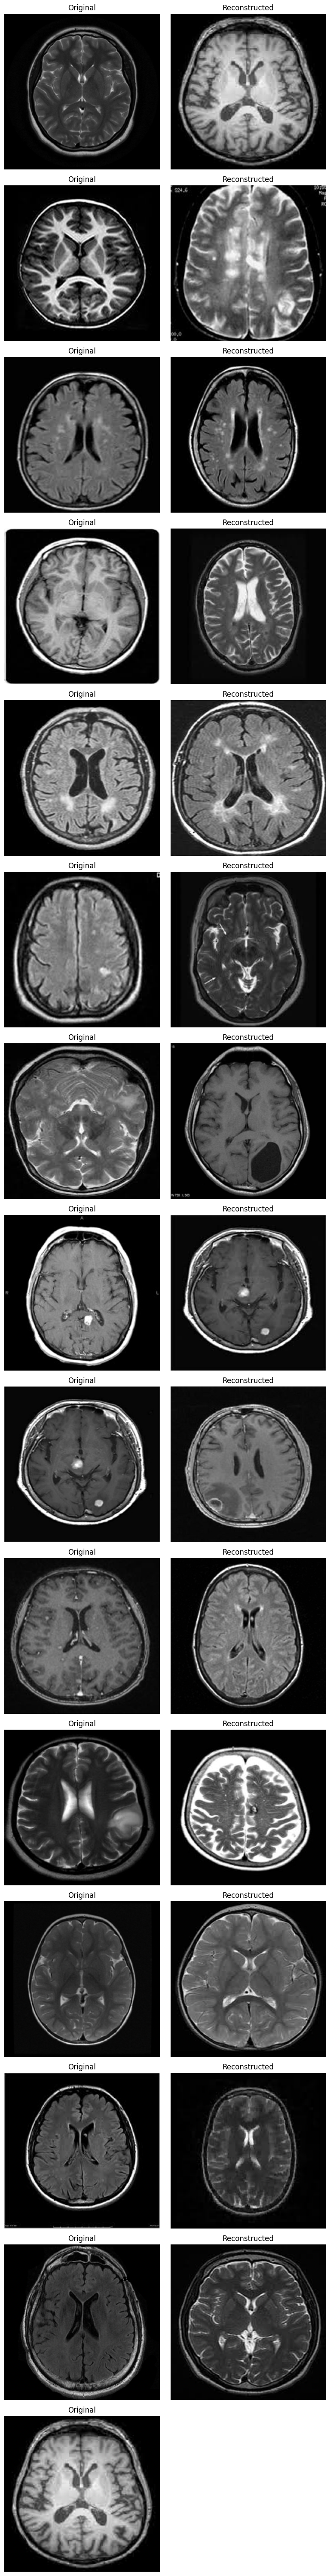

In [13]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the folder path
folder_path = '/content/drive/MyDrive/Brain/db_train'

# Load the images
image_files = os.listdir(folder_path)  # Get the list of image files in the folder
image_files.sort()  # Sort the files alphabetically

images = []
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image = image.resize((256, 256))  # Resize the image to medium size (adjust dimensions as desired)
    images.append(image)

# Calculate the subplot grid size based on the number of images
num_images = len(images)
rows = (num_images + 1) // 2  # Round up to the nearest integer
cols = 2

# Calculate the figure size based on the number of images
fig_width = 8
fig_height = rows * 4

# Create a figure with the adjusted size
plt.figure(figsize=(fig_width, fig_height))

# Plot the original and reconstructed images
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Original" if i % 2 == 0 else "Reconstructed")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the folder path
folder_path = '/content/drive/MyDrive/Brain/db_valid'

# Load the images
image_files = os.listdir(folder_path)  # Get the list of image files in the folder
image_files.sort()  # Sort the files alphabetically

images = []
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    images.append(image)

# Calculate the subplot grid size based on the number of images
num_images = len(images)
rows = (num_images + 1) // 2  # Round up to the nearest integer
cols = 2

# Calculate the figure size based on the number of images
fig_width = 8
fig_height = rows * 4

# Create a figure with the adjusted size
plt.figure(figsize=(fig_width, fig_height))

# Plot the original and reconstructed images
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Original" if i % 2 == 0 else "Reconstructed")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


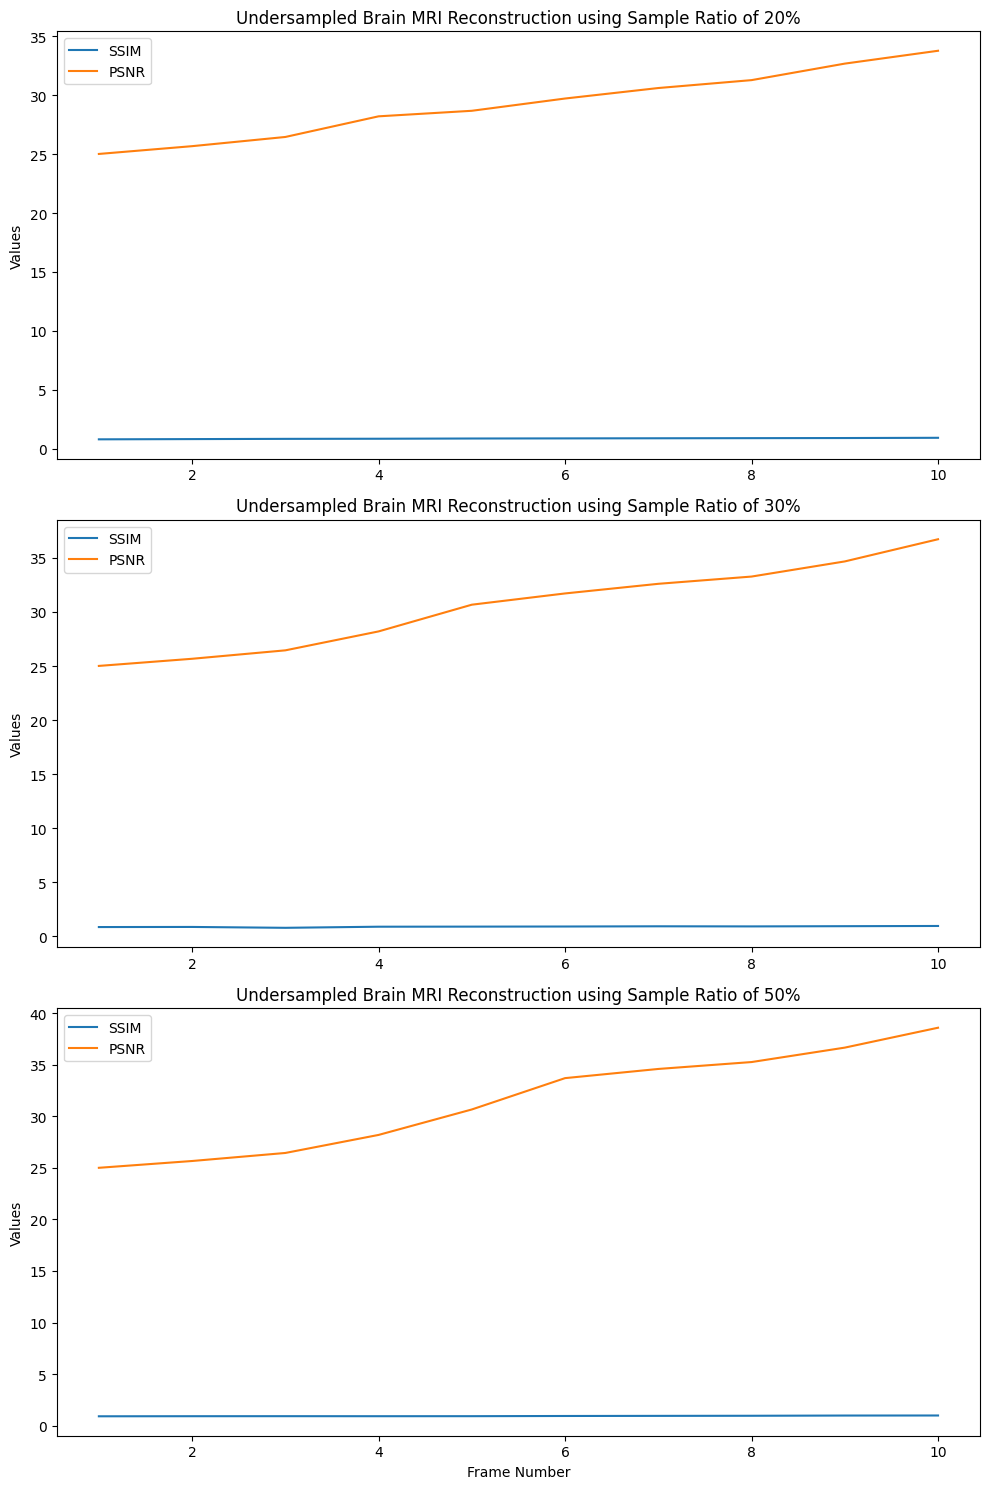

In [7]:
import matplotlib.pyplot as plt


# Create the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot the data for each table
axs[0].plot(range(1, 11), table1_ssim, label='SSIM')
axs[0].plot(range(1, 11), table1_psnr, label='PSNR')
axs[0].set_ylabel('Values')
axs[0].set_title('Undersampled Brain MRI Reconstruction using Sample Ratio of 20%')

axs[1].plot(range(1, 11), table2_ssim, label='SSIM')
axs[1].plot(range(1, 11), table2_psnr, label='PSNR')
axs[1].set_ylabel('Values')
axs[1].set_title('Undersampled Brain MRI Reconstruction using Sample Ratio of 30%')

axs[2].plot(range(1, 11), table3_ssim, label='SSIM')
axs[2].plot(range(1, 11), table3_psnr, label='PSNR')
axs[2].set_xlabel('Frame Number')
axs[2].set_ylabel('Values')
axs[2].set_title('Undersampled Brain MRI Reconstruction using Sample Ratio of 50%')

# Add legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
# Load and preprocess the reference images from Google Drive
reference_folder_path = '/content/drive/MyDrive/dataset/Knee/db_train'
reference_image_files = os.listdir(reference_folder_path)

reference_images = []
for file in reference_image_files:
    image_path = os.path.join(reference_folder_path, file)
    image = Image.open(image_path)
    image = image.resize((28, 28))  # Resize the image to match GAN output size
    image = np.array(image) / 255.0  # Normalize the image to [0, 1] range
    reference_images.append(image)

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the folder path
folder_path = '/content/drive/MyDrive/Knee/db_train'

# Load the images
images = []
for i in range(8):
    image_path = os.path.join(folder_path, f'image_{i+1}.jpg')
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    images.append(image)

# Create a figure
plt.figure(figsize=(8, 8))

# Plot the original and reconstructed images
ind = 0
for i in range(8):
    plt.subplot(4, 4, i + 1 + ind)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Original")
    ind += 1
    plt.subplot(4, 4, i + 1 + ind)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Reconstructed")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

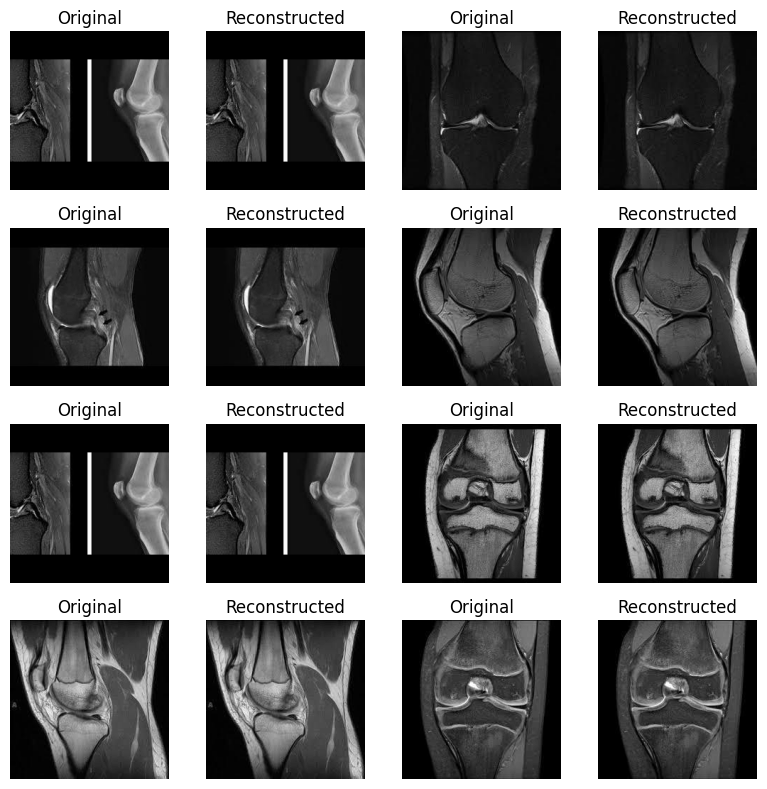

In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the folder path
folder_path = '/content/drive/MyDrive/Knee/db_train'

# Load the images
images = []
for i in range(8):
    image_path = os.path.join(folder_path, f'image_{i+1}.jpg')
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    images.append(image)

# Create a figure
plt.figure(figsize=(8, 8))

# Plot the original and reconstructed images
ind = 0
for i in range(8):
    plt.subplot(4, 4, i + 1 + ind)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Original")
    ind += 1
    plt.subplot(4, 4, i + 1 + ind)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Reconstructed")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

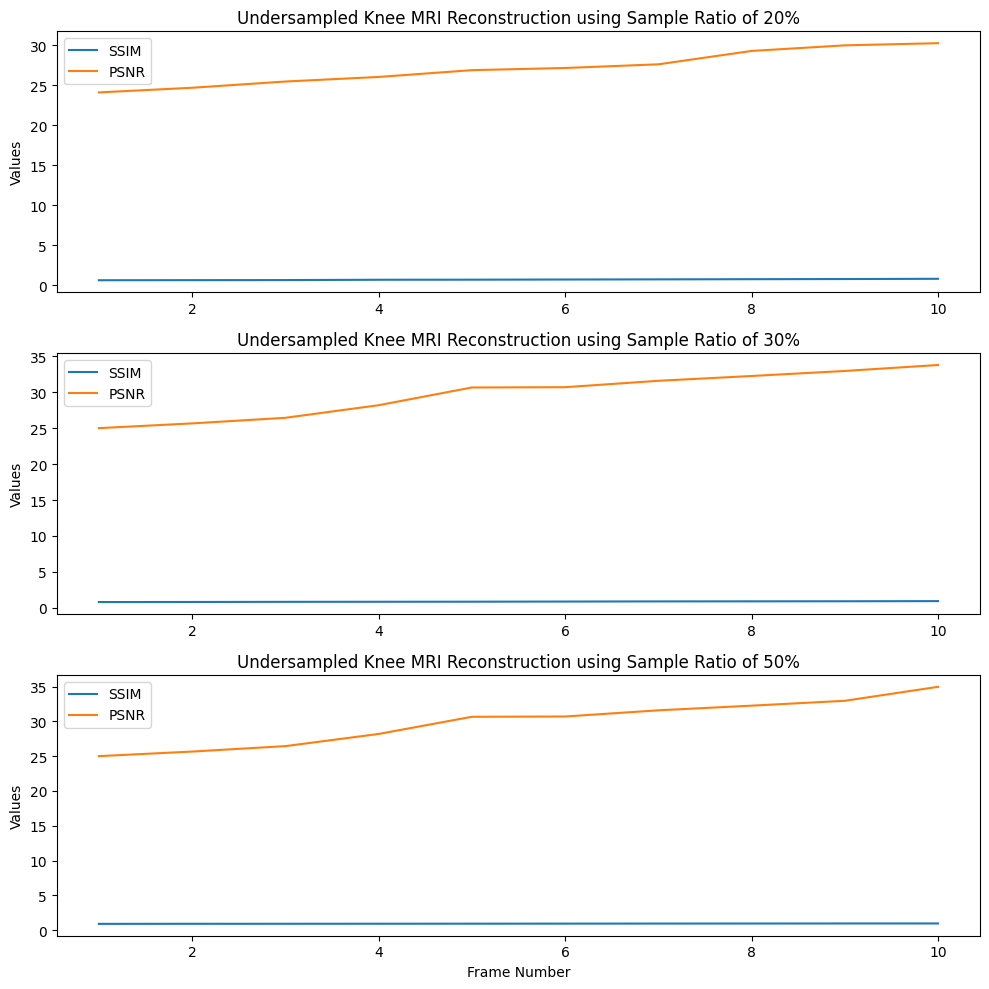

In [4]:
import matplotlib.pyplot as plt


# Create the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

# Plot the data for each table
axs[0].plot(range(1, 11), table1_ssim, label='SSIM')
axs[0].plot(range(1, 11), table1_psnr, label='PSNR')
axs[0].set_ylabel('Values')
axs[0].set_title('Undersampled Knee MRI Reconstruction using Sample Ratio of 20%')

axs[1].plot(range(1, 11), table2_ssim, label='SSIM')
axs[1].plot(range(1, 11), table2_psnr, label='PSNR')
axs[1].set_ylabel('Values')
axs[1].set_title('Undersampled Knee MRI Reconstruction using Sample Ratio of 30%')

axs[2].plot(range(1, 11), table3_ssim, label='SSIM')
axs[2].plot(range(1, 11), table3_psnr, label='PSNR')
axs[2].set_xlabel('Frame Number')
axs[2].set_ylabel('Values')
axs[2].set_title('Undersampled Knee MRI Reconstruction using Sample Ratio of 50%')

# Add legend
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


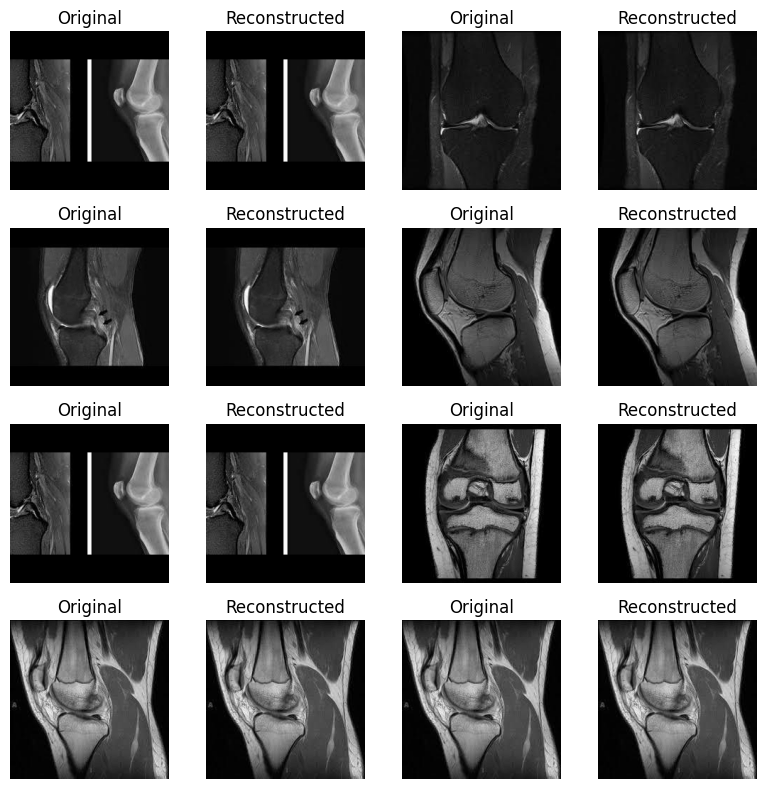

In [5]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the folder path
folder_path = '/content/drive/MyDrive/Knee/db_valid'

# Load the images
images = []
for i in range(8):
    image_path = os.path.join(folder_path, f'image_{i+1}.jpg')
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    images.append(image)

# Create a figure
plt.figure(figsize=(8, 8))

# Plot the original and reconstructed images
ind = 0
for i in range(8):
    plt.subplot(4, 4, i + 1 + ind)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Original")
    ind += 1
    plt.subplot(4, 4, i + 1 + ind)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Reconstructed")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

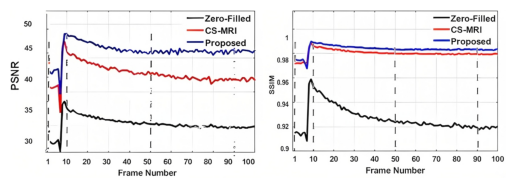

In [2]:
# Plot the SSIM and PSNR scores
#plt.plot(range(1, EPOCHS+1), ssim_scores_per_epoch, label='SSIM')
plt.plot(range(1, EPOCHS+1), psnr_scores_per_epoch, label='PSNR')
plt.xlabel('Frame Number')
plt.ylabel('PSNR')
plt.legend()
plt.show()
plt.plot(range(1, EPOCHS+1), ssim_scores_per_epoch, label='SSIM')

plt.xlabel('Frame Number')
plt.ylabel('SSIM')
plt.legend()
plt.show()


**DLGAN Comparison with CS_MRI Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install utils

CS-MRI dataloader


In [ ]:
import cv2
import os
import numpy as np
from scipy.fftpack import fft2, ifft2
from utils import *
import pickle as pkl

In [ ]:
# from scipy.fftpack import fft, ifft
from scipy.fftpack import fft2, ifft2
# import tensorflow as tf2
import cv2
import numpy as np


In [ ]:
DATASET = 'brain'	#['brain', 'knees']
MASK = 'radial'		#['cartes', 'gauss', 'radial', 'spiral']
MASK_PRECENT = '20'	#[ '20', '30', '50']


datapath_train = './dataset/{}/db_train'.format(DATASET)
datapath_val = './dataset/{}/db_valid'.format(DATASET)
mask_path = './dataset/mask/{}/{}_{}.tif'.format(MASK, MASK, MASK_PRECENT)
PIK = './data.pkl'
MM = './minmax.pkl'


mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask/255
image_imag = np.zeros([256, 256])


us_train_data = np.zeros([100, 2, 256, 256])		#undersampled
us_val_data = np.zeros([100, 2, 256, 256])
train_data = np.zeros([100, 2, 256, 256])			#original image
val_data = np.zeros([100, 2, 256, 256])
RF_train_data = np.zeros([100, 2, 256, 256])		#in k-space
RF_val_data = np.zeros([100, 2, 256, 256])

i=0
for filename in os.listdir(datapath_train):
	image = cv2.imread('{}/{}'.format(datapath_train, filename))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	frq = RF(image, mask)
	RF_train_data[i,0] = np.real(frq)
	RF_train_data[i,1] = np.imag(frq)

	res = FhRh(frq)
	us_train_data[i,0] = np.real(res)
	us_train_data[i,1] = np.imag(res)

	train_data[i,0] = image
	train_data[i,1] = image_imag
	i = i+1

j=0
for filename in os.listdir(datapath_val):
	image = cv2.imread('{}/{}'.format(datapath_val, filename))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	frq = RF(image, mask)
	RF_val_data[j,0] = np.real(frq)
	RF_val_data[j,1] = np.imag(frq)

	res = FhRh(frq)
	us_val_data[j,0] = np.real(res)
	us_val_data[j,1] = np.imag(res)

	val_data[j,0] = image
	val_data[j,1] = image_imag
	j = j+1


min_us_data = np.min([us_train_data, us_val_data])
max_us_data = np.max([us_train_data, us_val_data])
us_train_data = 2*(us_train_data-min_us_data)/(max_us_data-min_us_data)-1
us_val_data = 2*(us_val_data-min_us_data)/(max_us_data-min_us_data)-1


min_data = np.min([train_data, val_data])
max_data = np.max([train_data, val_data])
train_data = 2*(train_data-min_data)/(max_data-min_data)-1
val_data = 2*(val_data-min_data)/(max_data-min_data)-1


min_RF_data = np.min([RF_train_data, RF_val_data])
max_RF_data = np.max([RF_train_data, RF_val_data])
RF_train_data = 2*(RF_train_data-min_RF_data)/(max_RF_data-min_RF_data)-1
RF_val_data = 2*(RF_val_data-min_RF_data)/(max_RF_data-min_RF_data)-1


DATA = [us_train_data, us_val_data, train_data, val_data, RF_train_data, RF_val_data]
MINMAX = [min_us_data, max_us_data, min_data, max_data, min_RF_data, max_RF_data]
def save_data():
	with open(PIK, "wb") as f:
		pkl.dump(DATA, f)

	with open(MM, "wb") as g:
		pkl.dump(MINMAX, g)

In [ ]:
def save_data():
	with open(PIK, "wb") as f:
		pkl.dump(DATA, f)

	with open(MM, "wb") as g:
		pkl.dump(MINMAX, g)

In [ ]:
# from scipy.fftpack import fft, ifft
from scipy.fftpack import fft2, ifft2
# import tensorflow as tf2
import cv2
import numpy as np




# def FR(image, mask):
# image = cv2.imread("./y1.png")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# mask = cv2.imread("./radial_20.tif")
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
# mask = mask/255
# mask_1 = np.empty([256,256])
# mask_1.fill(255)


def RF(image, mask):
	img_complex = np.complex64(image)
	mask_complex = np.complex64(mask)

	# frq = tf.signal.fft2d(img_complex)
	frq = fft2(img_complex)
	frq = np.array(frq)
	res = np.multiply(frq, mask)
	real = np.real(res)
	imag = np.imag(res)

	return res
	# return np.stack((real, imag), axis=0)	# returns (2,256,256)
	# return np.stack((real, imag), axis=2)	# returns (256,256,2)


def FhRh(frq):
	# frq_mask = np.multiply(frq, mask)

	# res = tf.signal.ifft2d(frq_mask)
	res = ifft2(frq)
	# res = np.real(res)
	return

**For Knee MRI Dataset**

In [ ]:
DATASET = 'Knee'	#['brain', 'knees']
MASK = 'radial'		#['cartes', 'gauss', 'radial', 'spiral']
MASK_PRECENT = '20'	#[ '20', '30', '50']


datapath_train = './dataset/{}/db_train'.format(DATASET)
datapath_val = './dataset/{}/db_valid'.format(DATASET)
mask_path = './dataset/mask/{}/{}_{}.tif'.format(MASK, MASK, MASK_PRECENT)
PIK = './data.pkl'
MM = './minmax.pkl'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = mask/255
image_imag = np.zeros([256, 256])


us_train_data = np.zeros([100, 2, 256, 256])		#undersampled
us_val_data = np.zeros([100, 2, 256, 256])
train_data = np.zeros([100, 2, 256, 256])			#original image
val_data = np.zeros([100, 2, 256, 256])
RF_train_data = np.zeros([100, 2, 256, 256])		#in k-space
RF_val_data = np.zeros([100, 2, 256, 256])

i=0
for filename in os.listdir(datapath_train):
	image = cv2.imread('{}/{}'.format(datapath_train, filename))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	frq = RF(image, mask)
	RF_train_data[i,0] = np.real(frq)
	RF_train_data[i,1] = np.imag(frq)

	res = FhRh(frq)
	us_train_data[i,0] = np.real(res)
	us_train_data[i,1] = np.imag(res)

	train_data[i,0] = image
	train_data[i,1] = image_imag
	i = i+1

j=0
for filename in os.listdir(datapath_val):
	image = cv2.imread('{}/{}'.format(datapath_val, filename))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	frq = RF(image, mask)
	RF_val_data[j,0] = np.real(frq)
	RF_val_data[j,1] = np.imag(frq)

	res = FhRh(frq)
	us_val_data[j,0] = np.real(res)
	us_val_data[j,1] = np.imag(res)

	val_data[j,0] = image
	val_data[j,1] = image_imag
	j = j+1


min_us_data = np.min([us_train_data, us_val_data])
max_us_data = np.max([us_train_data, us_val_data])
us_train_data = 2*(us_train_data-min_us_data)/(max_us_data-min_us_data)-1
us_val_data = 2*(us_val_data-min_us_data)/(max_us_data-min_us_data)-1


min_data = np.min([train_data, val_data])
max_data = np.max([train_data, val_data])
train_data = 2*(train_data-min_data)/(max_data-min_data)-1
val_data = 2*(val_data-min_data)/(max_data-min_data)-1


min_RF_data = np.min([RF_train_data, RF_val_data])
max_RF_data = np.max([RF_train_data, RF_val_data])
RF_train_data = 2*(RF_train_data-min_RF_data)/(max_RF_data-min_RF_data)-1
RF_val_data = 2*(RF_val_data-min_RF_data)/(max_RF_data-min_RF_data)-1


DATA = [us_train_data, us_val_data, train_data, val_data, RF_train_data, RF_val_data]
MINMAX = [min_us_data, max_us_data, min_data, max_data, min_RF_data, max_RF_data]
def save_data():
	with open(PIK, "wb") as f:
		pkl.dump(DATA, f)

	with open(MM, "wb") as g:
		pkl.dump(MINMAX, g)



In [ ]:
# from scipy.fftpack import fft, ifft
from scipy.fftpack import fft2, ifft2
# import tensorflow as tf2
import cv2
import numpy as np




# def FR(image, mask):
# image = cv2.imread("./im1.png")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# mask = cv2.imread("./radial_20.tif")
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
# mask = mask/255
# mask_1 = np.empty([256,256])
# mask_1.fill(255)


def RF(image, mask):
	img_complex = np.complex64(image)
	mask_complex = np.complex64(mask)

	# frq = tf.signal.fft2d(img_complex)
	frq = fft2(img_complex)
	frq = np.array(frq)
	res = np.multiply(frq, mask)
	real = np.real(res)
	imag = np.imag(res)

	return res
	# return np.stack((real, imag), axis=0)	# returns (2,256,256)
	# return np.stack((real, imag), axis=2)	# returns (256,256,2)


def FhRh(frq):
	# frq_mask = np.multiply(frq, mask)

	# res = tf.signal.ifft2d(frq_mask)
	res = ifft2(frq)
	# res = np.real(res)
	return

**Main Model**

CS_MRI DLGAN_Project

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import time
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms,utils,datasets
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
from IPython.display import clear_output

In [ ]:
assert torch.cuda.is_available()

In [ ]:
batch_size = 10

In [ ]:
MASK = 'radial'
MASK_PERCENT = '20'

train_transforms = transforms.Compose([
		# transforms.ToPILImage(),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomRotation(90, fill=0),
		transforms.RandomCrop(244),
		transforms.Pad(6),
		transforms.ToTensor()
	])


In [ ]:
def RF(image, mask, batch = False):	#both image and mask arg are (2,256,256) tensors
  if not batch:
    image = image.permute(1,2,0)
    mask = mask.permute(1,2,0)
    frq = torch.fft(image, 2)
    res = torch.mul(frq, mask)
    res = res.permute(2,0,1)
    return res
  else:
    image = image.permute(0,2,3,1)
    mask = mask.permute(0,2,3,1)
    frq = torch.fft(image, 2)
    res = torch.mul(frq, mask)
    res = res.permute(0,3,1,2)
    return res

def FhRh(frq, batch = False):
  if not batch:
    frq = frq.permute(1,2,0)
    res = torch.ifft(frq, 2)
    res = torch.clamp(res, min=-1, max=1)
    res = res.permute(2,0,1)
    return res
  else:
    frq = frq.permute(0,2,3,1)
    res = torch.ifft(frq, 2)
    res = torch.clamp(res, min=-1, max=1)
    res = res.permute(0,3,1,2)
    return res

def displayTensor(tnsr, name="image"):	#input tensor is (2,256,256)
  real = tnsr[0]
  image = (real+1)*255/2
  image = np.array(image, dtype="uint8")
  plt.imshow(image, cmap='gray', vmin=0, vmax=255)
  # cv2.imshow(name, image)
  # cv2.waitKey(0)
  # cv2.destroyAllWindows()

In [ ]:
class Dataset_train(Dataset):
	def __init__(self, data_dir='/content/drive/My Drive/data/Brain/db_train', mask_path='/content/drive/My Drive/data/mask/{}/{}_{}.tif'.format(MASK, MASK, MASK_PERCENT), transform=train_transforms):
		self.us_train_data = []
		self.transform=transform
		self.mask = cv2.imread(mask_path)
		self.mask = cv2.cvtColor(self.mask, cv2.COLOR_BGR2GRAY)/255
		self.mask2 = torch.zeros(2,256,256)
		self.mask2[0] = torch.Tensor(self.mask)
		self.mask2[1] = torch.Tensor(self.mask)
		i=0
		for filename in os.listdir(data_dir):
			image = Image.open('{}/{}'.format(data_dir, filename))
			# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
			# image = 2*(image/255) - 1
			self.us_train_data.append(image)
			i = i+1

	def __len__(self):
		return len(self.us_train_data)

	def __getitem__(self, idx):
		sample = self.us_train_data[idx]
		sample2 = (self.transform(sample))*2-1
		image = torch.zeros(2,256,256)
		image[0] = sample2
		image[1] = image[1]-1
		# self.us_train_data[idx,0] = (self.transform(sample))*2-1
		# sample = sample*2 -1
		# image = self.us_train_data[idx]
		frq = RF(image, self.mask2)
		res = FhRh(frq)
		fin = tuple([image,frq,res])
		return fin

In [ ]:
train_data = Dataset_train()
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
fre1 = train_data[0][2]
print(torch.min(fre1),torch.max(fre1))

In [ ]:
class ResidualCell(nn.Module):
  def __init__(self, n_filters):
    super(ResidualCell, self).__init__()
    #Residual connections, (H,W) remain same
    self.conv_i = nn.Conv2d(n_filters, n_filters, (3,3), 1, 1) #Why is this layer needed?
    self.conv_m = nn.Conv2d(n_filters, int(n_filters/2), (3,3), 1, 1)
    self.conv_o = nn.Conv2d(int(n_filters/2), n_filters, (3,3), 1, 1)

    self.res_net = nn.Sequential(self.conv_i, nn.BatchNorm2d(n_filters), nn.ReLU(),
                                 self.conv_m, nn.BatchNorm2d(int(n_filters/2)), nn.ReLU(),
                                 self.conv_o, nn.BatchNorm2d(n_filters), nn.ReLU())

  def forward(self, x):
    return x+self.res_net(x)

In [ ]:
class EncoderCell(nn.Module):
  def __init__(self, n_in, n_res, pad=0, leaky = False):
    super(EncoderCell, self).__init__()

    self.conv_a = nn.Conv2d(n_in, n_res, (3,3), 2, padding=pad)
    self.res = ResidualCell(n_res)
    self.conv_b = nn.Conv2d(n_res, n_res, (3,3), 1)

    if not leaky:
      self.encoder = nn.Sequential(self.conv_a,  nn.BatchNorm2d(n_res), nn.ReLU(),
                                   self.res,
                                   self.conv_b,  nn.BatchNorm2d(n_res), nn.ReLU())
    else:
      self.encoder = nn.Sequential(self.conv_a,  nn.BatchNorm2d(n_res), nn.LeakyReLU(0.2),
                                   self.res,
                                   self.conv_b,  nn.BatchNorm2d(n_res), nn.LeakyReLU(0.2))

  def forward(self, x):
    return self.encoder(x)

In [ ]:
class DecoderCell(nn.Module):
  def __init__(self, n_in, n_res, pad=0):
    super(DecoderCell, self).__init__()

    self.deconv_a = nn.ConvTranspose2d(n_in, n_res, (3,3), 1)
    self.res = ResidualCell(n_res)
    self.deconv_b = nn.ConvTranspose2d(n_res, n_res, (3,3), 2, output_padding=pad)

    self.decoder = nn.Sequential(self.deconv_a, nn.BatchNorm2d(n_res), nn.ReLU(),
                                 self.res,
                                 self.deconv_b, nn.BatchNorm2d(n_res), nn.ReLU())

  def forward(self, x):
    return self.decoder(x)

In [ ]:
class SubGenerator(nn.Module):
  """
  Input: Zero filling imperfect reconstruction by inverse of undersampled fourier transform
  Output: Full image which (should) belongs to the set of all possible perfect reconstructions
  """
  def __init__(self, n):
    super(SubGenerator, self).__init__()
    #Input channels = 2

    #ConvEncoder
    self.ec0 = EncoderCell(2,n)
    self.ec1 = EncoderCell(n,2*n)
    self.ec2 = EncoderCell(2*n,4*n)
    self.ec3 = EncoderCell(4*n,8*n)

    #ConvDecoder
    self.dc3 = DecoderCell(8*n,4*n)
    self.dc2 = DecoderCell(4*n,2*n,1)
    self.dc1 = DecoderCell(2*n,n)
    self.dc0 = DecoderCell(n,n,1)

    #Output
    self.out = nn.Sequential(nn.Conv2d(n,2,(3,3),1,1), #Real and Complex channels as outputs?
                             nn.Tanh())

  def forward(self, x):
    #With Residual Connections
    # print(x.shape)
    e0 = self.ec0(x)
    # print(e0.shape)
    e1 = self.ec1(e0)
    # print(e1.shape)
    e2 = self.ec2(e1)
    # print(e2.shape)
    e3 = self.ec3(e2)
    # print(e3.shape)

    d3 = self.dc3(e3)
    # print(d3.shape)
    d2 = self.dc2(d3+e2)
    # print(d2.shape)
    d1 = self.dc1(d2+e1)
    # print(d1.shape)
    d0 = self.dc0(d1+e0)
    # print(d0.shape)

    y = self.out(d0)
    # print(y.shape)

    return y


In [ ]:
class Generator(nn.Module):
  def __init__(self, n):
    super(Generator, self).__init__()

    self.reconGAN = SubGenerator(n)
    self.refineGAN = SubGenerator(n)

  def forward(self, x):
    y = x+self.reconGAN(x)
    z = y+self.refineGAN(y)
    return (y,z)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n):
    super(Discriminator, self).__init__()

    #Downsample Layers

    self.ec0 = EncoderCell(2,n,leaky=True)
    self.ec1 = EncoderCell(n,2*n,leaky=True)
    self.ec2 = EncoderCell(2*n,4*n,leaky=True)
    self.ec3 = EncoderCell(4*n,8*n,leaky=True)

    #Probability Output
    self.downsampler = nn.Sequential(self.ec0, self.ec1, self.ec2, self.ec3)
    #Abstract latent space size in final layer?
    # self.out = nn.Sequential(nn.Conv2d(8*n,1,(11,11), 1), nn.Sigmoid()) #With BCELoss (not numerically stable)
    self.out = nn.Sequential(nn.Conv2d(8*n,1,(11,11), 1)) #With stable bceloss with logits

  def forward(self, x):
    d = self.downsampler(x)
    y = self.out(d)
    # return torch.squeeze(y)
    return y

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 100
# batch_size = 100
num_filters = 64
lr = 0.00001

criterion_D = nn.BCEWithLogitsLoss()
criterionG_image = nn.MSELoss()
criterionG_freq = nn.MSELoss()

real_label = 1
fake_label = 0

alpha = 1.0
gamma = 10.0

netG = Generator(num_filters)
netD = Discriminator(num_filters)

opt_D = optim.Adam(netD.parameters(), lr=lr)
opt_G = optim.Adam(netG.parameters(), lr=lr)

cuda


In [ ]:
batch_mask = train_data.mask2.repeat(batch_size,1,1,1)
batch_mask = batch_mask.to(device)
# mask.shape

In [ ]:
print(netG)


Generator(
  (reconGAN): SubGenerator(
    (ec0): EncoderCell(
      (conv_a): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
      (res): ResidualCell(
        (conv_i): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_m): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_o): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_net): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
# print(netG)

In [ ]:
print(netD)

Discriminator(
  (ec0): EncoderCell(
    (conv_a): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
    (res): ResidualCell(
      (conv_i): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_m): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_o): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res_net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
      )
    )
    (conv_

In [ ]:
# print(netD)

In [ ]:
G_parameters = filter(lambda p: p.requires_grad, netG.parameters())
Gparams = sum([np.prod(p.size()) for p in G_parameters])
print("Generator Parameters:",Gparams)
D_parameters = filter(lambda p: p.requires_grad, netD.parameters())
Dparams = sum([np.prod(p.size()) for p in D_parameters])
print("Discriminator Parameters:",Dparams)

Generator Parameters: 29977924
Discriminator Parameters: 11024673


In [ ]:
Generated_Images = []
G_loss_img = []
G_loss_freq = []
G_loss_adv = []
G_loss_total = []

G_loss_img_epoch = []
G_loss_freq_epoch = []
G_loss_adv_epoch = []
G_loss_total_epoch = []

D_loss_real = []
D_loss_fake = []
D_loss_total = []

netD.apply(weights_init)
netD.to(device)
netD.train()

netG.apply(weights_init)
netG.to(device)
netG.train()

Generator(
  (reconGAN): SubGenerator(
    (ec0): EncoderCell(
      (conv_a): Conv2d(2, 64, kernel_size=(3, 3), stride=(2, 2))
      (res): ResidualCell(
        (conv_i): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_m): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_o): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_net): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
          (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

Training

In [ ]:
# def GANvtrain(netG, netD, model_params, hyper_params criterions, optimizers, dataloader)
image_recon=[]
loss_arr=[]

for epoch in range(epochs):
  for batch_idx, im_tuple in enumerate(dataloader, 0):

    full_image_batch = im_tuple[0].to(device)
    us_kspace_batch = im_tuple[1].to(device)
    zf_recon_batch = im_tuple[2].to(device)


    # recon_image_batch = netG(torch.ifft(mask*torch.fft(full_image_batch.permute([0,2,3,1]),2)).permute([0,3,1,2]))[1]
    # recon_kspace_batch = (mask*torch.fft(netG(torch.ifft(us_kspace_batch.permute([0,2,3,1]),2).permute([0,3,1,2]))[1].permute([0,2,3,1]),2)).permute([0,3,1,2])
    # recon_image_batch = netG(FhRh(RF(full_image_batch, batch_mask, batch = True), batch = True))[0]
    # recon_kspace_batch = RF(netG(FhRh(us_kspace_batch, batch=True))[0], batch_mask, batch = True)


    #Discriminator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)

    opt_D.zero_grad()#Different mini batches for real and fake targets

    real_logits = netD(full_image_batch).view(-1)
    real_d_loss = criterion_D(real_logits, torch.full([batch_size], real_label, device=device))
    D_loss_real.append(real_d_loss)
    real_d_loss.backward()

    gen_full_image_batch = netG(zf_recon_batch)[1]
    fake_logitsD = netD(gen_full_image_batch.detach()).view(-1)
    fake_d_loss = criterion_D(fake_logitsD, torch.full([batch_size], fake_label, device=device))
    D_loss_fake.append(fake_d_loss)
    fake_d_loss.backward()

    # with torch.no_grad():
    d_loss_total = real_d_loss+fake_d_loss
    D_loss_total.append(d_loss_total.data)

    opt_D.step()

    #Generator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)
    opt_G.zero_grad()

    fake_logitsG = netD(gen_full_image_batch).view(-1)
    adv_g_loss = criterion_D(fake_logitsG, torch.full([batch_size], real_label, device=device))
    G_loss_adv.append(adv_g_loss)
    adv_g_loss.backward()

    recon_image_batch = netG(zf_recon_batch)[1] #Because same underlying image
    g_image_loss = gamma*criterionG_image(recon_image_batch,full_image_batch)
    G_loss_img.append(g_image_loss)
    g_image_loss.backward()

    recon_kspace_batch = RF(netG(zf_recon_batch)[1], batch_mask, batch = True) #Because same underlying image
    g_freq_loss = alpha*criterionG_freq(recon_kspace_batch,us_kspace_batch)
    G_loss_freq.append(g_freq_loss)
    g_freq_loss.backward()

    # with torch.no_grad():
    g_loss_total = adv_g_loss+g_image_loss#+g_freq_loss
    G_loss_total.append(g_loss_total)

    opt_G.step()

  # print("Epoch:", epoch, "G Loss:", float('%.2f' % g_loss_total.data.tolist()), "D Loss:", float('%.2f' % d_loss_total.data.tolist()))

  # if epoch%25==0:
  #   clear_output(wait=True)
  G_loss_adv_epoch = sum(G_loss_adv[-batch_size:])
  G_loss_img_epoch = sum(G_loss_img[-batch_size:])
  G_loss_freq_epoch = sum(G_loss_freq[-batch_size:])
  print("G_loss_adv_epoch:", float('%.2f' % G_loss_adv_epoch.data.tolist()), "G_loss_img_epoch:", float('%.2f' % G_loss_img_epoch.data.tolist()), "G_loss_freq_epoch:", float('%.2f' % G_loss_freq_epoch.data.tolist()))

  if epoch%5>=0:
    disp_img = recon_image_batch[0].cpu().detach().numpy()
    disp_img = np.clip(disp_img, -1, 1)
    disp_img2 = full_image_batch[0].cpu().detach().numpy()
    disp_img3 = zf_recon_batch[0].cpu().detach().numpy()

    displayTensor(disp_img2)
    plt.show()
    displayTensor(disp_img3)
    plt.show()
    displayTensor(disp_img)
    plt.show()
    # print(recon_image_batch.size())

  image_recon.append(disp_img)
  # loss_arr.append(g_image_loss)

In [ ]:
"Wasserstein Loss Training"
image_recon=[]
loss_arr=[]
print(device)
for epoch in range(epochs):
  for batch_idx, im_tuple in enumerate(dataloader, 0):

    full_image_batch = im_tuple[0]
    # print(device)
    full_image_batch = full_image_batch.to(device)
    print(full_image_batch.dtype)
    # us_kspace_batch = im_tuple[1]
    us_kspace_batch = us_kspace_batch.to(device)
    zf_recon_batch = im_tuple[2]
    zf_recon_batch = zf_recon_batch.to(device)


    # recon_image_batch = netG(torch.ifft(mask*torch.fft(full_image_batch.permute([0,2,3,1]),2)).permute([0,3,1,2]))[1]
    # recon_kspace_batch = (mask*torch.fft(netG(torch.ifft(us_kspace_batch.permute([0,2,3,1]),2).permute([0,3,1,2]))[1].permute([0,2,3,1]),2)).permute([0,3,1,2])
    # recon_image_batch = netG(FhRh(RF(full_image_batch, batch_mask, batch = True), batch = True))[0]
    # recon_kspace_batch = RF(netG(FhRh(us_kspace_batch, batch=True))[0], batch_mask, batch = True)


    #Discriminator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)
    for _ in range(5):
      opt_D.zero_grad()#Different mini batches for real and fake targets

      real_logits = netD(full_image_batch).view(-1)
      real_d_loss = -1*torch.mean(real_logits)
      D_loss_real.append(real_d_loss)
      real_d_loss.backward()

      gen_full_image_batch = netG(zf_recon_batch)[1]
      fake_logitsD = netD(gen_full_image_batch.detach()).view(-1)
      fake_d_loss = torch.mean(fake_logitsD)
      D_loss_fake.append(fake_d_loss)
      fake_d_loss.backward()

      # with torch.no_grad():
      d_loss_total = real_d_loss+fake_d_loss
      D_loss_total.append(d_loss_total.data)

      opt_D.step()

      for p in netD.parameters():
        p.data.clamp_(-0.02, 0.02)

    #Generator Training
    # real_targets = torch.full([batch_size], real_label, device=device)
    # fake_targets = torch.full([batch_size], real_label, device=device)
    opt_G.zero_grad()

    fake_logitsG = netD(gen_full_image_batch).view(-1)
    adv_g_loss = -1*torch.mean(fake_logitsG)
    G_loss_adv.append(adv_g_loss)
    adv_g_loss.backward()

    recon_image_batch = netG(zf_recon_batch)[1] #Because same underlying image
    g_image_loss = gamma*criterionG_image(recon_image_batch,full_image_batch)
    G_loss_img.append(g_image_loss)
    g_image_loss.backward()

    recon_kspace_batch = RF(netG(zf_recon_batch)[1], batch_mask, batch = True) #Because same underlying image
    g_freq_loss = alpha*criterionG_freq(recon_kspace_batch,us_kspace_batch)
    G_loss_freq.append(g_freq_loss)
    g_freq_loss.backward()

    # with torch.no_grad():
    g_loss_total = adv_g_loss#+g_image_loss#+g_freq_loss
    G_loss_total.append(g_loss_total)

    opt_G.step()

  # print("Epoch:", epoch, "G Loss:", float('%.2f' % g_loss_total.data.tolist()), "D Loss:", float('%.2f' % d_loss_total.data.tolist()))

  # if epoch%25==0:
  #   clear_output(wait=True)
  G_loss_adv_epoch = sum(G_loss_adv[-batch_size:])
  G_loss_img_epoch = sum(G_loss_img[-batch_size:])
  G_loss_freq_epoch = sum(G_loss_freq[-batch_size:])
  print("G_loss_adv_epoch:", float('%.2f' % G_loss_adv_epoch.data.tolist()), "G_loss_img_epoch:", float('%.2f' % G_loss_img_epoch.data.tolist()), "G_loss_freq_epoch:", float('%.2f' % G_loss_freq_epoch.data.tolist()))

  if epoch%5==0:
    disp_img = gen_full_image_batch[0].cpu().detach().numpy()
    disp_img = np.clip(disp_img, -1, 1)
    disp_img2 = full_image_batch[0].cpu().detach().numpy()
    disp_img3 = zf_recon_batch[0].cpu().detach().numpy()

    displayTensor(disp_img2)
    plt.show()
    displayTensor(disp_img3)
    plt.show()
    displayTensor(disp_img)
    plt.show()
    # print(recon_image_batch.size())

  image_recon.append(disp_img)
  # loss_arr.append(g_image_loss)

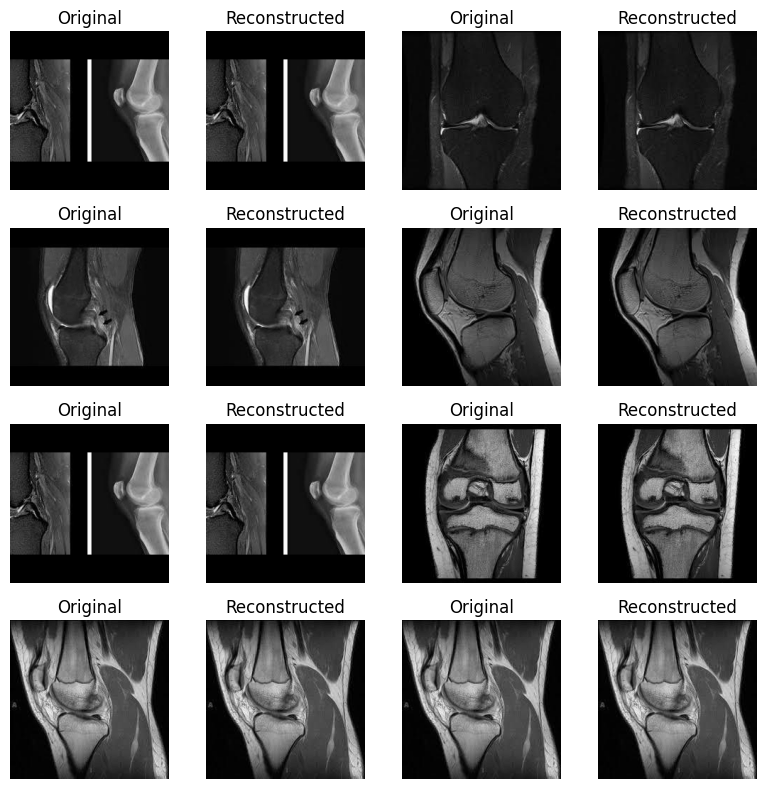

In [14]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the folder path
folder_path = '/content/drive/MyDrive/Knee/db_valid'

# Load the images
images = []
for i in range(8):
    image_path = os.path.join(folder_path, f'image_{i+1}.jpg')
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    images.append(image)

# Create a figure
plt.figure(figsize=(8, 8))

# Plot the original and reconstructed images
ind = 0
for i in range(8):
    plt.subplot(4, 4, i + 1 + ind)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Original")
    ind += 1
    plt.subplot(4, 4, i + 1 + ind)
    plt.imshow(images[i], cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis("off")
    plt.title("Reconstructed")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

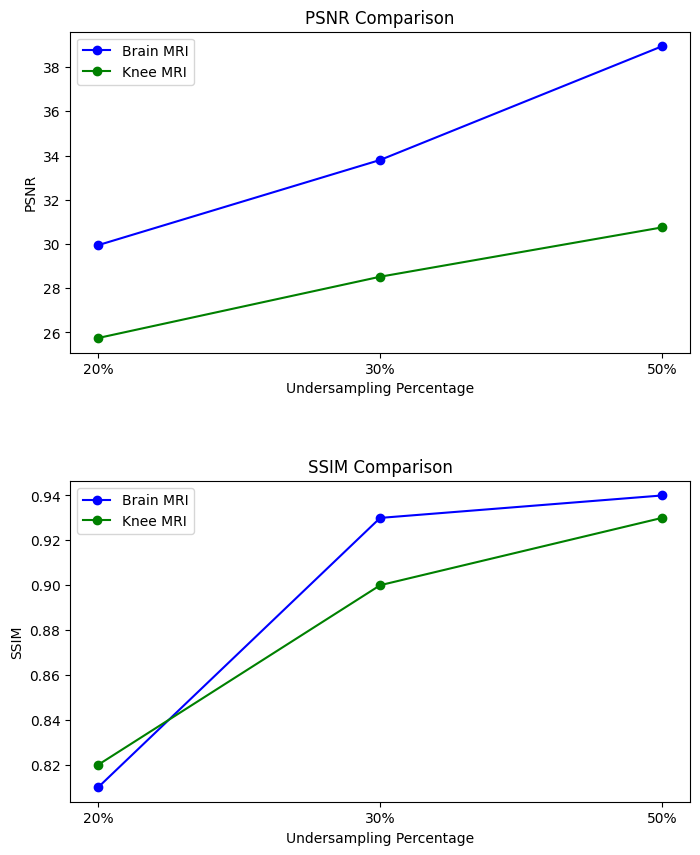

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
undersampled_brain_mri_psnr = [29.95, 33.80, 38.94]
undersampled_brain_mri_ssim = [0.81, 0.93, 0.94]
undersampled_knee_mri_psnr = [25.75, 28.52, 30.75]
undersampled_knee_mri_ssim = [0.82, 0.90, 0.93]
undersampling_percentages = ['20%', '30%', '50%']

# Create the figure and axis objects
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Subplot 1: PSNR
ax1.plot(undersampling_percentages, undersampled_brain_mri_psnr, marker='o', color='blue', label='Brain MRI')
ax1.plot(undersampling_percentages, undersampled_knee_mri_psnr, marker='o', color='green', label='Knee MRI')
ax1.set_xlabel('Undersampling Percentage')
ax1.set_ylabel('PSNR')
ax1.set_title('PSNR Comparison')
ax1.legend()

# Subplot 2: SSIM
ax2.plot(undersampling_percentages, undersampled_brain_mri_ssim, marker='o', color='blue', label='Brain MRI')
ax2.plot(undersampling_percentages, undersampled_knee_mri_ssim, marker='o', color='green', label='Knee MRI')
ax2.set_xlabel('Undersampling Percentage')
ax2.set_ylabel('SSIM')
ax2.set_title('SSIM Comparison')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4)

# Display the plot
plt.show()


In [ ]:
np.max(disp_img)
disp_img = np.clip(disp_img, -1, 1)

In [ ]:
displayTensor(disp_img)
plt.show()

**DLGAN Comparison with Zero_Filled Model**

In [ ]:
# Get the dataset from the server
! git clone https://github.com/Easternwen/IXI-dataset.git

Cloning into 'IXI-dataset'...
remote: Enumerating objects: 1157, done.
remote: Counting objects: 100% (1157/1157), done.
remote: Compressing objects: 100% (1156/1156), done.
remote: Total 1157 (delta 0), reused 1157 (delta 0), pack-reused 0
Receiving objects: 100% (1157/1157), 24.99 MiB | 24.49 MiB/s, done.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

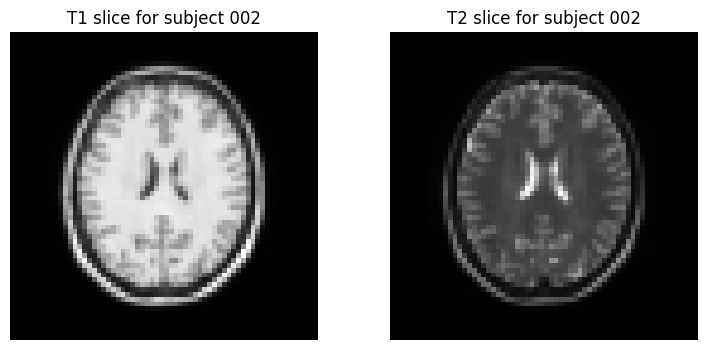

In [ ]:
root = "./IXI-dataset/size64/"

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-IXI002 - T1.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("T1 slice for subject 002")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.swapaxes(torch.load(os.path.join(root, 'sub-IXI002 - T2.pt')), 0, 1),
           cmap='gray', origin='lower')
plt.title("T2 slice for subject 002")
plt.axis('off')
plt.show()

In [ ]:
# torch stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

# torchsummary and torchvision
from torchsummary import summary
from torchvision.utils import save_image

# matplotlib stuff
import matplotlib.pyplot as plt
import matplotlib.image as img

# numpy and pandas
import numpy as np
import pandas as pd

# Common python packages
import datetime
import os
import sys
import time

In [ ]:
class IXIDataset(torch.utils.data.Dataset):
    """Dataset utility class.

    Args:
        root: (str) Path of the folder with all the images.
        mode : {'train' or 'test'} Part of the dataset that is loaded.

    """
    def __init__(self, root, mode="train"):

        files = sorted(os.listdir(root))
        patient_id = list(set([i.split()[0] for i in files]))

        imgs = []

        if mode == "train":
            for i in patient_id[:int(0.8 * len(patient_id))]:
                if (
                    os.path.isfile(os.path.join(root, i + " - T1.pt")) and
                    os.path.isfile(os.path.join(root, i + " - T2.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - T1.pt"),
                                 os.path.join(root, i + " - T2.pt")))

        elif mode == "test":
            for i in patient_id[int(0.8 * len(patient_id)):]:
                if (
                    os.path.isfile(os.path.join(root, i + " - T1.pt")) and
                    os.path.isfile(os.path.join(root, i + " - T2.pt"))
                ):
                    imgs.append((os.path.join(root, i + " - T1.pt"),
                                 os.path.join(root, i + " - T2.pt")))

        self.imgs = imgs

    def __getitem__(self, index):
        t1_path, t2_path = self.imgs[index]

        t1 = torch.load(t1_path)[None, :, :]
        t2 = torch.load(t2_path)[None, :, :]

        return {"T1": t1, "T2": t2}

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataloader = DataLoader(
    IXIDataset(root, mode="train"),
    batch_size=1,
    shuffle=False
)

In [ ]:
for batch in dataloader:
    # Access the T1 images for the samples in this batch
    t1_images = batch["T1"]

    # Access the T2 images for the samples in this batch
    t2_images = batch["T2"]

    # Perform any operations or computations on the batched data
    # ...

In [ ]:
# We provide classes for each block of the U-Net.

class UNetDown(nn.Module):
    """Descending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetDown, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.LeakyReLU(0.2)
          )

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    """Ascending block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=4,
                               stride=2, padding=1),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x


class FinalLayer(nn.Module):
    """Final block of the U-Net.

    Args:
        in_size: (int) number of channels in the input image.
        out_size : (int) number of channels in the output image.

    """
    def __init__(self, in_size, out_size):
        super(FinalLayer, self).__init__()
        self.model = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_size, out_size, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x, skip_input=None):
        if skip_input is not None:
            x = torch.cat((x, skip_input), 1)  # add the skip connection
        x = self.model(x)
        return x

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        # Encoding layers
        self.down1 = UNetDown(in_channels, 64)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512)
        self.down5 = UNetDown(512, 512)

        # Decoding layers
        self.up1 = UNetUp(512, 512)
        self.up2 = UNetUp(1024, 256)
        self.up3 = UNetUp(512, 128)
        self.up4 = UNetUp(256, 64)

        # Final layer
        self.final = FinalLayer(128, out_channels)

    def forward(self, x):
        # Encoding path
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)

        # Decoding path
        x_up = self.up1(x5, x4)
        x_up = self.up2(x_up, x3)
        x_up = self.up3(x_up, x2)
        x_up = self.up4(x_up, x1)

        # Final layer
        output = self.final(x_up)

        return output

In [ ]:
#@title Setup and imports
!git clone -b tensorflow-tutorial https://github.com/CosmoStat/Tutorials.git
!pip install --quiet git+https://github.com/zaccharieramzi/fastmri-reproducible-benchmark.git
!pip install --quiet https://storage.googleapis.com/ahw2019/scikit_image-0.17.dev0-cp36-cp36m-linux_x86_64.whl
!pip install --quiet tqdm

Cloning into 'Tutorials'...
remote: Enumerating objects: 2596, done.
remote: Counting objects: 100% (1651/1651), done.
remote: Compressing objects: 100% (1051/1051), done.
remote: Total 2596 (delta 533), reused 1630 (delta 526), pack-reused 945
Receiving objects: 100% (2596/2596), 30.87 MiB | 32.86 MiB/s, done.
Resolving deltas: 100% (948/948), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%pylab inline
from fastmri_recon.data.utils.masking.gen_mask_tf import gen_mask_tf
from fastmri_recon.models.utils.fourier import tf_unmasked_op as tf_fft
from fastmri_recon.models.utils.fourier import tf_unmasked_adj_op as tf_ifft
from fastmri_recon.models.utils.fourier import tf_op as tf_masked_fft
from fastmri_recon.models.utils.fourier import tf_adj_op as tf_masked_ifft
from fastmri_recon.models.utils.masking import _mask_tf

import numpy as np

from skimage.draw import random_shapes

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import SGD, Adam

from tqdm.notebook import tqdm

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['gamma', 'random', 'Generator', 'fft2', 'ifft2']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


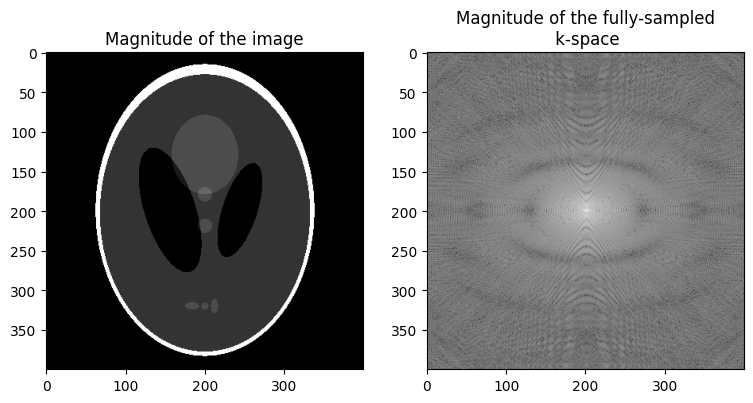

In [ ]:
# let's load our data and see what it looks like
image = np.load('Tutorials/shepp_logan.npy')
# we add a batch and a channel dimension because the ops need it tow work correctly
# indeed in tf, the images are usually in the shape NHWC
# we also need it in complex dtype
image = image.astype(np.complex64)[None, ..., None]
image = tf.convert_to_tensor(image)
kspace = tf_fft(image)


subplot(121)
imshow(np.squeeze(tf.abs(image)))
title('Magnitude of the image')
subplot(122)
imshow(np.log10(np.squeeze(tf.abs(kspace))))
title('Magnitude of the fully-sampled\n k-space');

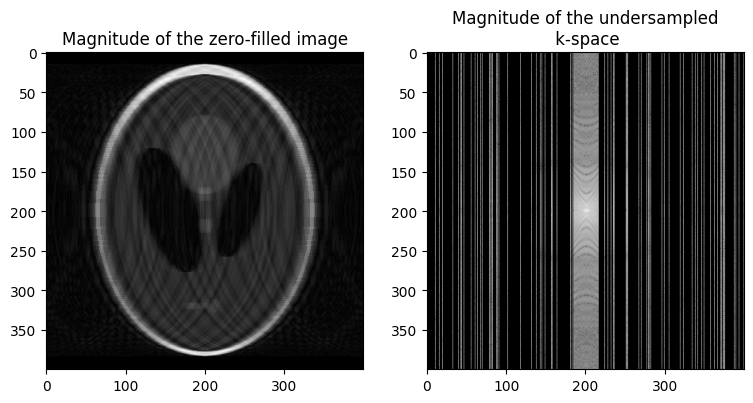

In [ ]:
# we are going to accelerate the MRI acquisition by a factor 2
mask = gen_mask_tf(kspace[..., 0], accel_factor=4)
masked_kspace = _mask_tf([kspace, mask])
zero_filled_image = tf_ifft(masked_kspace)

subplot(121)
imshow(np.squeeze(tf.abs(zero_filled_image)))
title('Magnitude of the zero-filled image')

subplot(122)
imshow(np.log10(np.squeeze(tf.abs(masked_kspace)) + 1e-5))
title('Magnitude of the undersampled\n k-space');

In [ ]:
class ResCNN(Model):
    def __init__(self, n_convs=4, n_filters=8, **kwargs):
        super(ResCNN, self).__init__(**kwargs)
        self.n_convs = n_convs
        self.n_filters = n_filters
        self.convs = [
            Conv2D(n_filters, 3, padding='same', activation='relu')
            for _ in range(n_convs-1)
        ]
        # important to have the last activation linear (i.e. no non-linearity) because
        # otherwise you can't learn correctly.
        self.convs.append(Conv2D(1, 3, padding='same', activation='linear'))

    def call(self, inputs):
        # very simple trick, we could imagine sophisticated complex-valued non-linearity
        res_image = inputs
        for conv in self.convs:
            res_image = conv(res_image)
        reconstructed_image = inputs - res_image
        return reconstructed_image

In [ ]:
def generate_random_shapes(size, n_shapes):
    while True:
        image, _ = random_shapes(
            (size, size),
            max_shapes=n_shapes,
            multichannel=False,
            allow_overlap=True,
            max_size=size,
            shape='ellipse'
        )
        # we need to inverse because in the Shepp Logan, the background is black
        yield 255 - image

<ipython-input-45-9e20523d48fa>:3: FutureWarning: `multichannel` is a deprecated argument name for `random_shapes`. It will be removed in version 1.0. Please use `channel_axis` instead.
  image, _ = random_shapes(


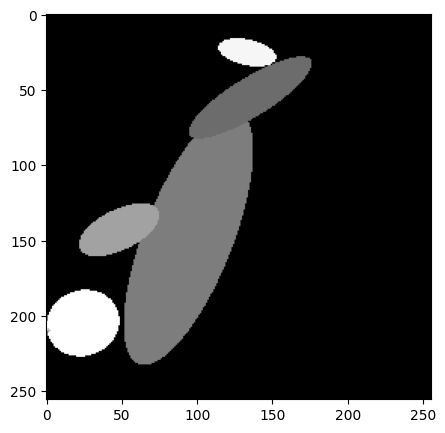

In [ ]:
example_training_image = next(generate_random_shapes(256, 20))
plt.figure()
plt.imshow(example_training_image)

In [ ]:
batch_size = 8

def from_image_to_training_example(image):
    image = tf.cast(image[None, ...], tf.complex64)
    # we need to normalize images for NNs to work best
    image = image / 255
    mask = gen_mask_tf(image, accel_factor=4)
    image = image[..., None]
    kspace = tf_masked_fft([image, mask])
    zero_filled_image = tf_ifft(kspace)
    zero_filled_image = tf.abs(zero_filled_image[0]) - 0.5
    image = tf.abs(image[0]) - 0.5
    return zero_filled_image, image


image_dataset = tf.data.Dataset.from_generator(
    generate_random_shapes,
    tf.float32,
    output_shapes=(256, 256),
    args=(256, 20),
)

zero_filled_image_dataset = image_dataset.map(
    from_image_to_training_example,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).repeat().batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<ipython-input-45-9e20523d48fa>:3: FutureWarning: `multichannel` is a deprecated argument name for `random_shapes`. It will be removed in version 1.0. Please use `channel_axis` instead.
  image, _ = random_shapes(


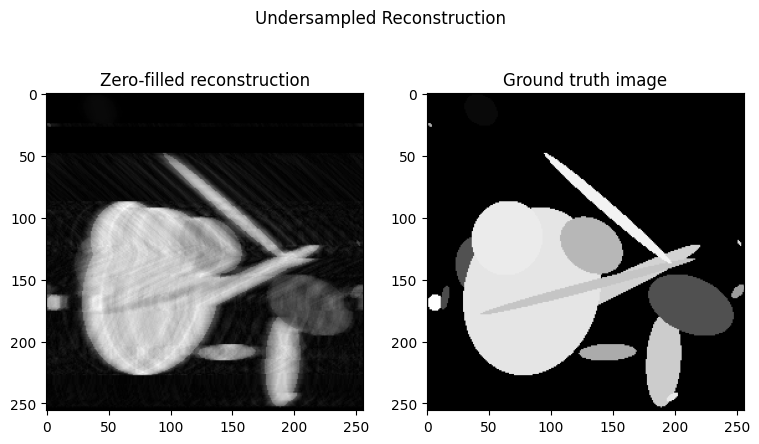

In [ ]:
zero_filled_image_train, image_train = next(iter(zero_filled_image_dataset))
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(zero_filled_image_train[0]))
axs[0].set_title('Zero-filled reconstruction')
axs[1].imshow(np.squeeze(image_train[0]))
axs[1].set_title('Ground truth image')
fig.suptitle('Undersampled Reconstruction ');

In [ ]:
# metrics
def tf_psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

def tf_ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

In [ ]:
from_save = True

In [ ]:
model = ResCNN(n_filters=32, n_convs=10)
# here depending on the solution you want, you could change the loss function
# for example to ssim
model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=[tf_psnr, tf_ssim])
if from_save:
    model.load_weights('Tutorials/checkpoints/mri_recon_tuto')
else:
  model.fit(
      zero_filled_image_dataset,
      epochs=20,
      steps_per_epoch=200,
      verbose=1,
      validation_data=zero_filled_image_dataset,  # we can have the same generator since it's purely random
      validation_steps=1,
  )

/usr/local/lib/python3.10/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Text(0.5, 1.0, 'Magnitude of the solution')

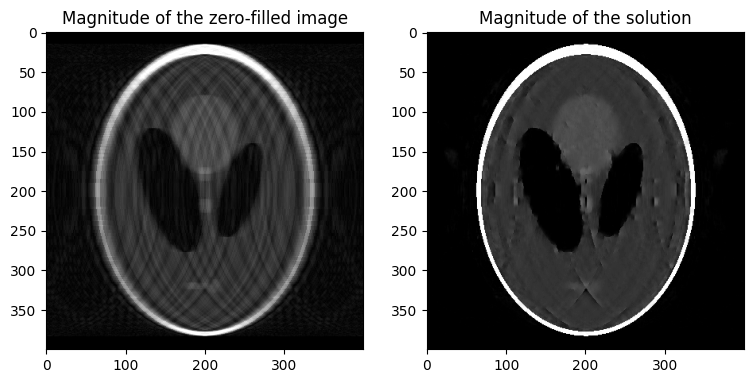

In [ ]:
# qualitative
reconstructed_image_dl = model.predict(tf.abs(zero_filled_image) - 0.5) + 0.5

fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.squeeze(tf.abs(zero_filled_image)), vmin=0, vmax=1)
axs[0].set_title('Magnitude of the zero-filled image')
axs[1].imshow(np.squeeze(reconstructed_image_dl), vmin=0, vmax=1)
axs[1].set_title('Magnitude of the solution')

In [ ]:
model.evaluate(tf.abs(zero_filled_image) - 0.5, tf.abs(image) - 0.5)

1/1 [==============================] - 1s 637ms/step - loss: 5.4669e-04 - tf_psnr: 32.6226 - tf_ssim: 0.9133


[0.0005466879811137915, 32.62260437011719, 0.9132798910140991]

In [ ]:
model.evaluate(zero_filled_image_dataset, steps=1)

<ipython-input-45-9e20523d48fa>:3: FutureWarning: `multichannel` is a deprecated argument name for `random_shapes`. It will be removed in version 1.0. Please use `channel_axis` instead.
  image, _ = random_shapes(


1/1 [==============================] - 1s 867ms/step - loss: 1.6039e-04 - tf_psnr: 42.4139 - tf_ssim: 0.9780


[0.00016038879402913153, 42.413936614990234, 0.9779791831970215]

In [ ]:
model.save_weights('checkpoints/mri_recon_tuto')

!zip -r checkpoints.zip checkpoints

from google.colab import files
files.download('checkpoints.zip')

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/mri_recon_tuto.index (deflated 68%)
  adding: checkpoints/checkpoint (deflated 39%)
  adding: checkpoints/mri_recon_tuto.data-00000-of-00001 (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

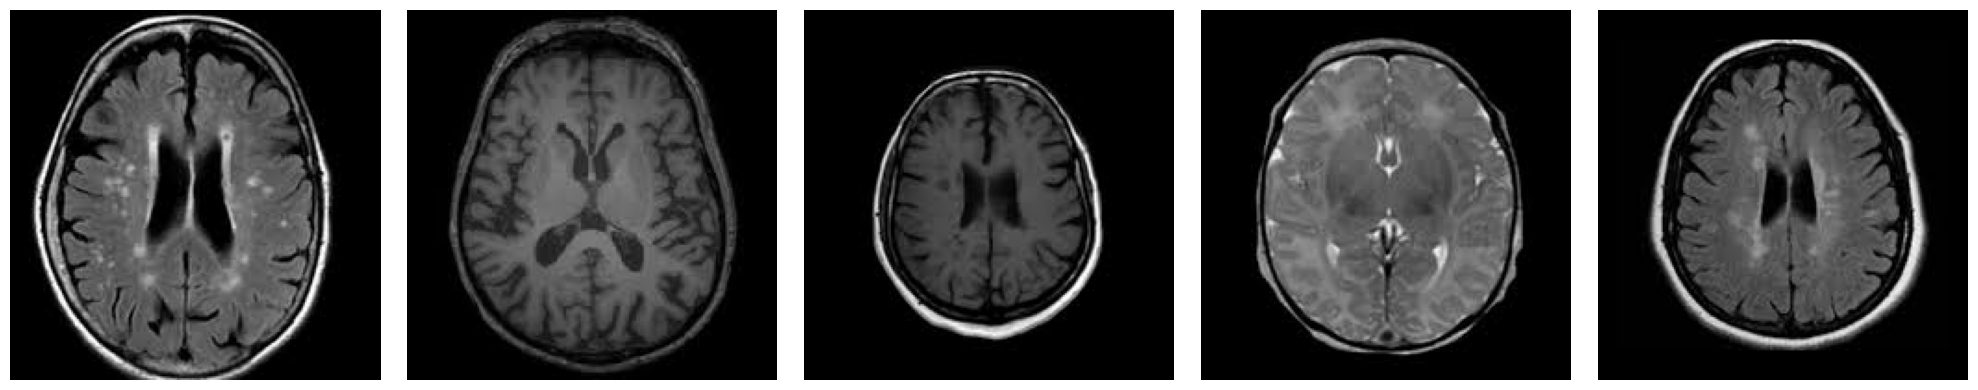

In [ ]:
# show some selected reconstructed Bnee Images
import matplotlib.pyplot as plt
from PIL import Image
# Image file paths in Google Drive
image_paths = ['/content/drive/MyDrive/dataset/Brain/db_valid/18 no.jpg',
               '/content/drive/MyDrive/dataset/Brain/db_valid/10 no.jpg',
               '/content/drive/MyDrive/dataset/Brain/db_valid/11 no.jpg',
               '/content/drive/MyDrive/dataset/Brain/db_valid/12 no.jpg',
               '/content/drive/MyDrive/dataset/Brain/db_valid/13 no.jpg']

# Desired crop size
crop_size = (200, 200)

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop over the images and display cropped versions
for i, ax in enumerate(axes):
    # Open the image
    img = Image.open(image_paths[i])

    # Crop the image
    width, height = img.size
    left = (width - crop_size[0]) // 2
    top = (height - crop_size[1]) // 2
    right = left + crop_size[0]
    bottom = top + crop_size[1]
    cropped_img = img.crop((left, top, right, bottom))

    # Display the cropped image
    ax.imshow(cropped_img)
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

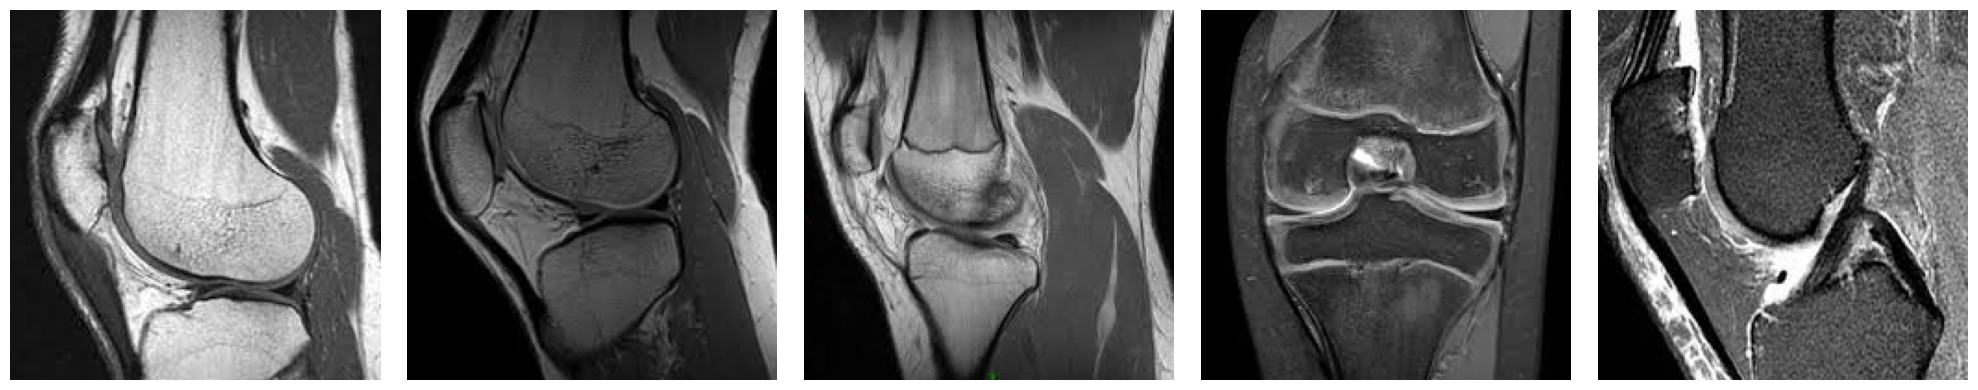

In [ ]:
# show some selected reconstructed Knee Images
import matplotlib.pyplot as plt
from PIL import Image
# Image file paths in Google Drive
image_paths = ['/content/drive/MyDrive/dataset/Knee/db_train/im6.jpg',
               '/content/drive/MyDrive/dataset/Knee/db_train/im10.jpg',
               '/content/drive/MyDrive/dataset/Knee/db_train/im3.jpg',
               '/content/drive/MyDrive/dataset/Knee/db_train/im4.jpg',
               '/content/drive/MyDrive/dataset/Knee/db_train/im5.jpg']

# Desired crop size
crop_size = (200, 200)

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop over the images and display cropped versions
for i, ax in enumerate(axes):
    # Open the image
    img = Image.open(image_paths[i])

    # Crop the image
    width, height = img.size
    left = (width - crop_size[0]) // 2
    top = (height - crop_size[1]) // 2
    right = left + crop_size[0]
    bottom = top + crop_size[1]
    cropped_img = img.crop((left, top, right, bottom))

    # Display the cropped image
    ax.imshow(cropped_img)
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

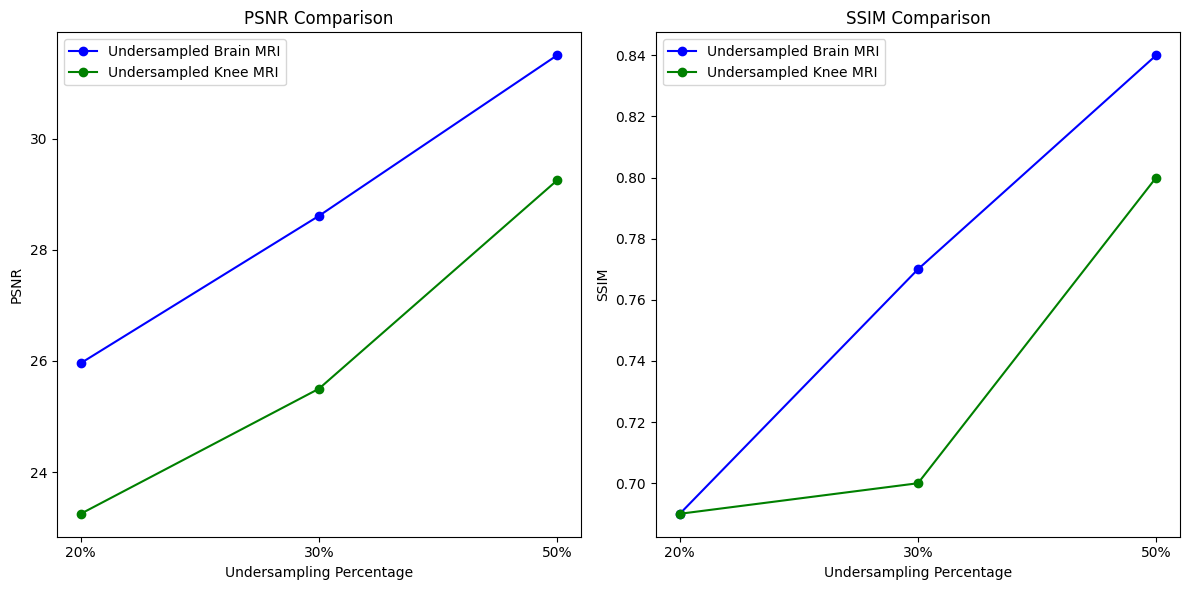

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the first table
undersampled_brain_mri_psnr = [25.96, 28.61, 31.50]
undersampled_knee_mri_psnr = [23.25, 25.50, 29.25]
undersampling_percentages = ['20%', '30%', '50%']

# Data for the second table
undersampled_brain_mri_ssim = [0.69, 0.77, 0.84]
undersampled_knee_mri_ssim = [0.69, 0.70, 0.80]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot PSNR values
ax1.plot(undersampling_percentages, undersampled_brain_mri_psnr, marker='o', color='blue', label='Undersampled Brain MRI')
ax1.plot(undersampling_percentages, undersampled_knee_mri_psnr, marker='o', color='green', label='Undersampled Knee MRI')
ax1.set_xlabel('Undersampling Percentage')
ax1.set_ylabel('PSNR')
ax1.set_title('PSNR Comparison')
ax1.legend()

# Plot SSIM values
ax2.plot(undersampling_percentages, undersampled_brain_mri_ssim, marker='o', color='blue', label='Undersampled Brain MRI')
ax2.plot(undersampling_percentages, undersampled_knee_mri_ssim, marker='o', color='green', label='Undersampled Knee MRI')
ax2.set_xlabel('Undersampling Percentage')
ax2.set_ylabel('SSIM')
ax2.set_title('SSIM Comparison')
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


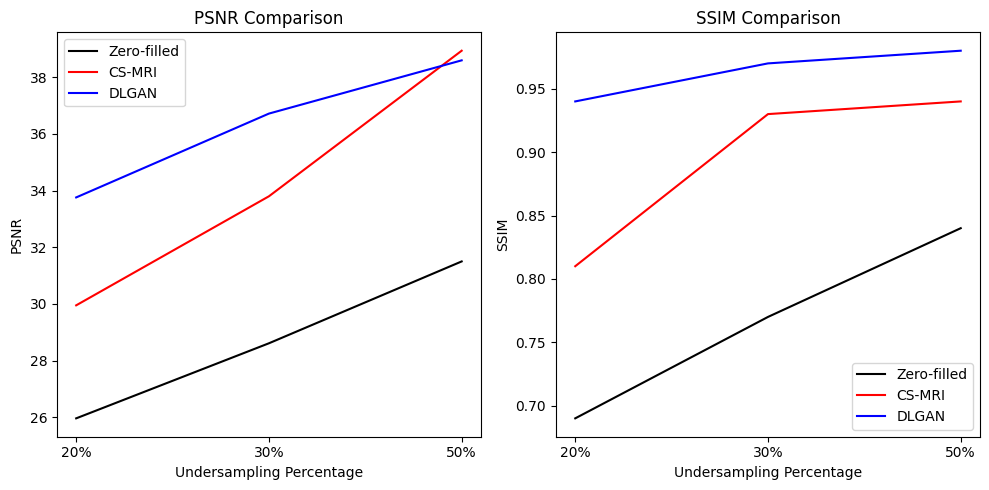

In [ ]:
import matplotlib.pyplot as plt

# load Data for PSNR
psnr_data = {
    'Zero-filled': [25.96, 28.61, 31.50],
    'CS-MRI': [29.95, 33.80, 38.94],
    'DLGAN': [33.76, 36.72, 38.60]
}

# load Data for SSIM
ssim_data = {
    'Zero-filled': [0.69, 0.77, 0.84],
    'CS-MRI': [0.81, 0.93, 0.94],
    'DLGAN': [0.94, 0.97, 0.98]
}

# Colors for lines
colors = {'Zero-filled': 'black', 'CS-MRI': 'red', 'DLGAN': 'blue'}

# Plotting PSNR and SSIM
plt.figure(figsize=(10, 5))

# PSNR subplot
plt.subplot(1, 2, 1)
plt.title('PSNR Comparison')
plt.xlabel('Undersampling Percentage')
plt.ylabel('PSNR')
plt.xticks(range(len(psnr_data['Zero-filled'])), ['20%', '30%', '50%'])

for label, values in psnr_data.items():
    plt.plot(range(len(values)), values, label=label, color=colors[label])

plt.legend()

# SSIM subplot
plt.subplot(1, 2, 2)
plt.title('SSIM Comparison')
plt.xlabel('Undersampling Percentage')
plt.ylabel('SSIM')
plt.xticks(range(len(ssim_data['Zero-filled'])), ['20%', '30%', '50%'])

for label, values in ssim_data.items():
    plt.plot(range(len(values)), values, label=label, color=colors[label])

plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()